In [64]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError


stock_data = yf.download('TSLA', start='2020-04-08', end='2023-10-31')
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-08,36.946667,37.147331,35.555332,36.589333,36.589333,189840000
2020-04-09,37.472668,38.345333,37.140667,38.200001,38.200001,204750000
2020-04-13,39.344002,43.466667,38.702000,43.396667,43.396667,337131000
2020-04-14,46.598000,49.458668,46.161999,47.326000,47.326000,458647500
2020-04-15,49.466667,50.208668,47.333332,48.655334,48.655334,353655000


Text(0, 0.5, 'Prices ($)')

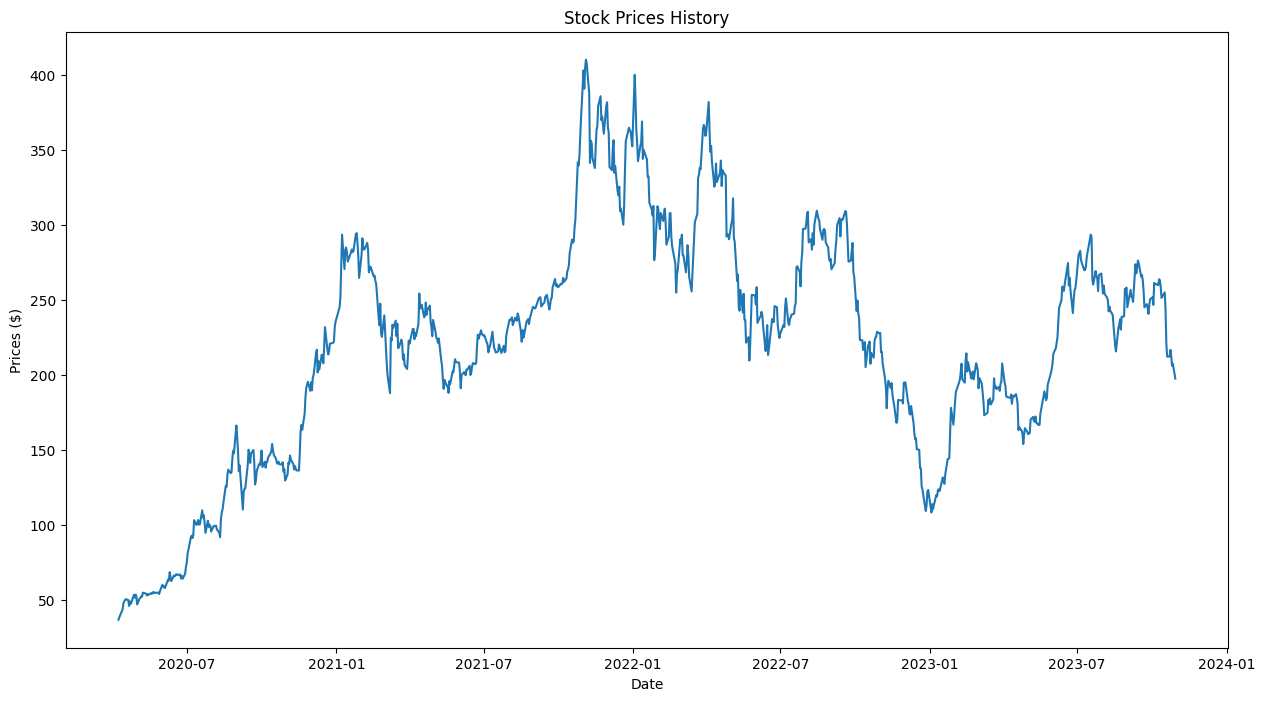

In [66]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [67]:
close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [68]:
# 20% test set
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [69]:
# Build the LSTM with 24 neurons and 1 layer.
model = Sequential()
model.add(LSTM(units=24, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(1))

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 24)                2496      
                                                                 
 dropout_16 (Dropout)        (None, 24)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 25        
                                                                 
Total params: 2521 (9.85 KB)
Trainable params: 2521 (9.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [57]:
#model = keras.Sequential()
#model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
#model.add(layers.LSTM(100, return_sequences=False))
#model.add(layers.Dense(25))
#model.add(layers.Dense(1))
#model.summary()

# Select Best Epoch and Batch Size

In [70]:
import time

In [71]:
model.compile(optimizer='adam', loss='mean_squared_error')
start_time = time.time()
history = model.fit(x_train, y_train, batch_size= 4, epochs=20, validation_split=0.2)
end_time = time.time()


Epoch 1/20
132/132 [==============================] - 2s 10ms/step - loss: 0.0671 - val_loss: 0.0047
Epoch 2/20
132/132 [==============================] - 1s 8ms/step - loss: 0.0127 - val_loss: 0.0037
Epoch 3/20
132/132 [==============================] - 1s 8ms/step - loss: 0.0089 - val_loss: 0.0030
Epoch 4/20
132/132 [==============================] - 1s 8ms/step - loss: 0.0094 - val_loss: 0.0034
Epoch 5/20
132/132 [==============================] - 1s 8ms/step - loss: 0.0078 - val_loss: 0.0026
Epoch 6/20
132/132 [==============================] - 1s 8ms/step - loss: 0.0068 - val_loss: 0.0034
Epoch 7/20
132/132 [==============================] - 1s 8ms/step - loss: 0.0055 - val_loss: 0.0031
Epoch 8/20
132/132 [==============================] - 1s 8ms/step - loss: 0.0062 - val_loss: 0.0030
Epoch 9/20
132/132 [==============================] - 1s 8ms/step - loss: 0.0052 - val_loss: 0.0020
Epoch 10/20
132/132 [==============================] - 1s 8ms/step - loss: 0.0048 - val_loss: 0.001

In [72]:
# Convert the loss history to a numpy array
loss_history = np.array(history.history['loss'])

# Calculate summary statistics
mean_loss = np.mean(loss_history)
std_loss = np.std(loss_history)
min_loss = np.min(loss_history)
max_loss = np.max(loss_history)

# Print summary statistics
print('Mean loss:', mean_loss)
print('Standard deviation of loss:', std_loss)
print('Minimum loss:', min_loss)
print('Maximum loss:', max_loss)
# Choose the best epoch
best_epoch = np.argmin(loss_history) + 1
print('Best epoch:', best_epoch)

Mean loss: 0.00886673660716042
Standard deviation of loss: 0.01354577555652081
Minimum loss: 0.003481320571154356
Maximum loss: 0.06707363575696945
Best epoch: 20


In [73]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

6/6 [==============================] - 0s 2ms/step


3.7654944052243366

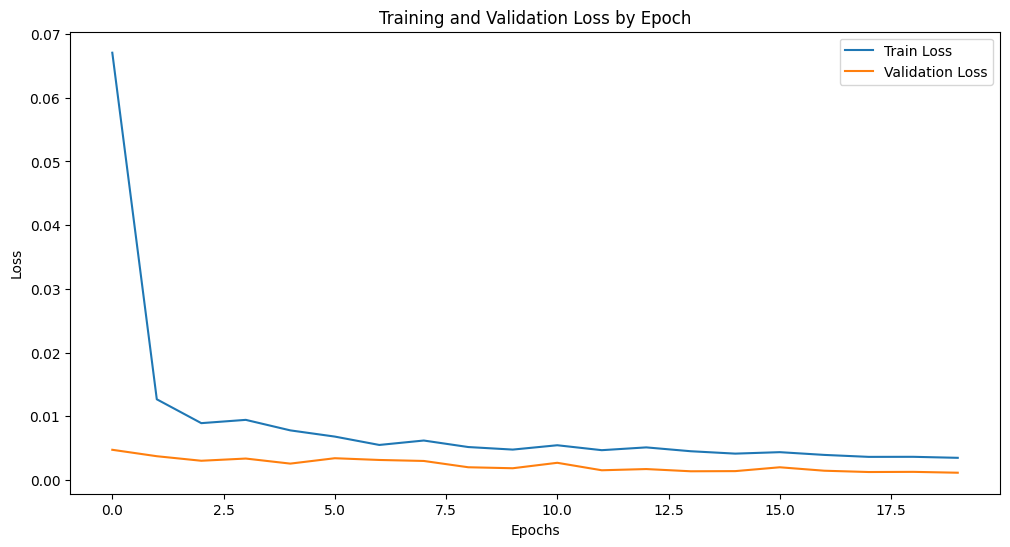

In [74]:
# Plotting the training and validation loss for each epoch
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss by Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Select Best Batch Size

In [75]:
# Select best Batch
batch_sizes = [1, 24, 32, 64]
batch_loss = []  # This will store the final loss for each batch size
batch_time = []  # This will store the running time for each batch size
batch_loss_histories = []  # This will store the loss history for each batch size
validation_split = 0.2


for batch_size in batch_sizes:
    model1 = Sequential()
    model1.add(LSTM(units=24, input_shape=(x_train.shape[1], 1)))
    model1.add(Dropout(0.2))
    model1.add(Dense(1))
    model1.compile(optimizer='adam', loss='mean_squared_error')


    start_time1 = time.time()
    history1 = model1.fit(x_train, y_train, epochs=20, batch_size=batch_size, validation_split=validation_split)
    end_time1 = time.time()

    # Append the final loss for this batch size to batch_loss
    batch_loss.append(history1.history['loss'][-1])

    # Append the total time for this batch size to batch_time
    batch_time.append(end_time1 - start_time1)
    # Append the loss history for this batch size to batch_loss_histories
    batch_loss_histories.append(history1.history['loss'])

Epoch 1/20
526/526 [==============================] - 4s 5ms/step - loss: 0.0306 - val_loss: 0.0034
Epoch 2/20
526/526 [==============================] - 3s 5ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 3/20
526/526 [==============================] - 3s 6ms/step - loss: 0.0072 - val_loss: 0.0018
Epoch 4/20
526/526 [==============================] - 3s 5ms/step - loss: 0.0057 - val_loss: 0.0025
Epoch 5/20
526/526 [==============================] - 3s 5ms/step - loss: 0.0049 - val_loss: 0.0025
Epoch 6/20
526/526 [==============================] - 3s 5ms/step - loss: 0.0040 - val_loss: 0.0012
Epoch 7/20
526/526 [==============================] - 3s 5ms/step - loss: 0.0036 - val_loss: 0.0015
Epoch 8/20
526/526 [==============================] - 3s 5ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 9/20
526/526 [==============================] - 3s 5ms/step - loss: 0.0034 - val_loss: 0.0011
Epoch 10/20
526/526 [==============================] - 3s 5ms/step - loss: 0.0033 - val_loss: 0.0011

In [76]:
# Find the best batch size based on the final loss
best_batch_size = batch_sizes[np.argmin(batch_loss)]
print('The best batch size is:', best_batch_size)

# Print the running time for each batch size
for i in range(len(batch_sizes)):
    print(f"Running time for batch size {batch_sizes[i]}: {batch_time[i]} seconds")

The best batch size is: 1
Running time for batch size 1: 54.666056871414185 seconds
Running time for batch size 24: 5.467314958572388 seconds
Running time for batch size 32: 4.666077136993408 seconds
Running time for batch size 64: 3.4227850437164307 seconds


# Best Neurone Size

In [78]:
# Find the best neurone
batch_size2 = 1
epochs2 = 20
neurons = [50, 100, 150, 200, 300]

# This will store the final loss for each number of neurons
neuron_loss = []

# This will store the running time for each number of neurons
neuron_time = []

# This will store the loss history for each number of neurons
loss_histories = []

# This will store the models
models = []

predictions = []  # This will store the predictions for each number of neurons

for n in neurons:
    model2 = Sequential()
    model2.add(LSTM(units=n, input_shape=(x_train.shape[1], 1)))
    model2.add(Dropout(0.2))
    model2.add(Dense(1))
    model2.compile(optimizer='adam', loss='mean_squared_error')

    start_time2 = time.time()
    history2 = model2.fit(x_train, y_train, epochs=epochs2, batch_size=batch_size2, validation_split=0.2)
    end_time2 = time.time()

    # Append the final loss for this number of neurons to neuron_loss
    neuron_loss.append(history2.history['loss'][-1])

    # Append the total time for this number of neurons to neuron_time
    neuron_time.append(end_time2 - start_time2)

    # Append the loss history for this number of neurons to loss_histories
    loss_histories.append(history2.history['loss'])

    # Generate predictions for this model and append to predictions list
    stock_pred = model2.predict(x_test)
    stock_pred = scaler.inverse_transform(stock_pred)
    predictions.append(stock_pred)

Epoch 1/20
526/526 [==============================] - 4s 6ms/step - loss: 0.0162 - val_loss: 0.0019
Epoch 2/20
526/526 [==============================] - 3s 6ms/step - loss: 0.0053 - val_loss: 0.0015
Epoch 3/20
526/526 [==============================] - 3s 6ms/step - loss: 0.0046 - val_loss: 0.0024
Epoch 4/20
526/526 [==============================] - 3s 6ms/step - loss: 0.0041 - val_loss: 0.0010
Epoch 5/20
526/526 [==============================] - 3s 6ms/step - loss: 0.0035 - val_loss: 9.3169e-04
Epoch 6/20
526/526 [==============================] - 3s 6ms/step - loss: 0.0040 - val_loss: 0.0013
Epoch 7/20
526/526 [==============================] - 3s 6ms/step - loss: 0.0032 - val_loss: 0.0010
Epoch 8/20
526/526 [==============================] - 3s 6ms/step - loss: 0.0027 - val_loss: 7.7196e-04
Epoch 9/20
526/526 [==============================] - 3s 6ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 10/20
526/526 [==============================] - 3s 6ms/step - loss: 0.0025 - val_loss

In [79]:
#Model Summary
for i, n in enumerate(neurons):
    loss_history_np = np.array(loss_histories[i])

    print(f"Loss History Summary Statistics for Neuron Size {n}:")
    print("Mean:", np.mean(loss_history_np))
    print("Standard Deviation:", np.std(loss_history_np))
    print("Minimum:", np.min(loss_history_np))
    print("Maximum:", np.max(loss_history_np))
    print("\n")

Loss History Summary Statistics for Neuron Size 50:
Mean: 0.0033982553868554533
Standard Deviation: 0.0031094520683955643
Minimum: 0.0015761747490614653
Maximum: 0.016155488789081573


Loss History Summary Statistics for Neuron Size 100:
Mean: 0.0025108415924478323
Standard Deviation: 0.001460912964988428
Minimum: 0.001521427882835269
Maximum: 0.008162764832377434


Loss History Summary Statistics for Neuron Size 150:
Mean: 0.002474202495068312
Standard Deviation: 0.001336089050519417
Minimum: 0.0014340921770781279
Maximum: 0.007503689266741276


Loss History Summary Statistics for Neuron Size 200:
Mean: 0.002327957935631275
Standard Deviation: 0.001105588039866399
Minimum: 0.001357631292194128
Maximum: 0.006270885467529297


Loss History Summary Statistics for Neuron Size 300:
Mean: 0.0022976507840212434
Standard Deviation: 0.0012418024518168276
Minimum: 0.0013569893781095743
Maximum: 0.006910583004355431




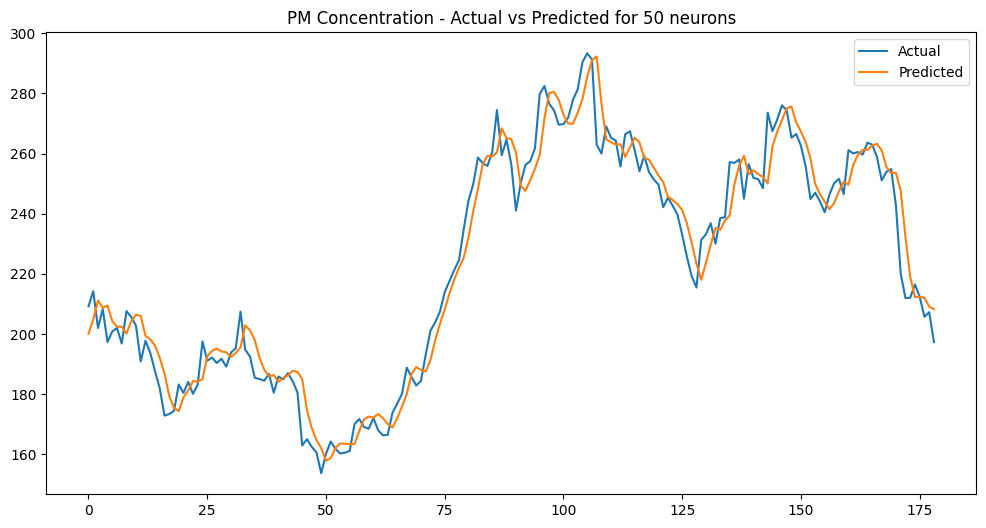

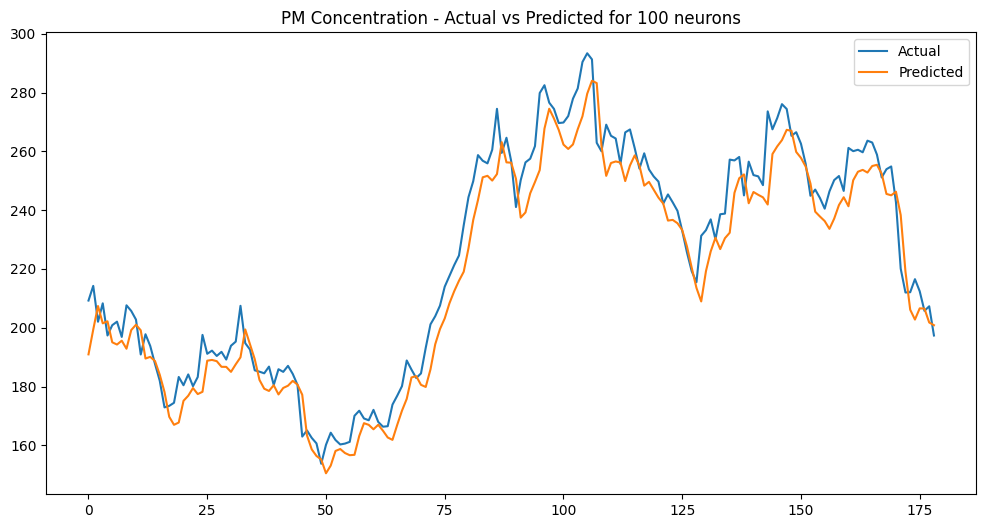

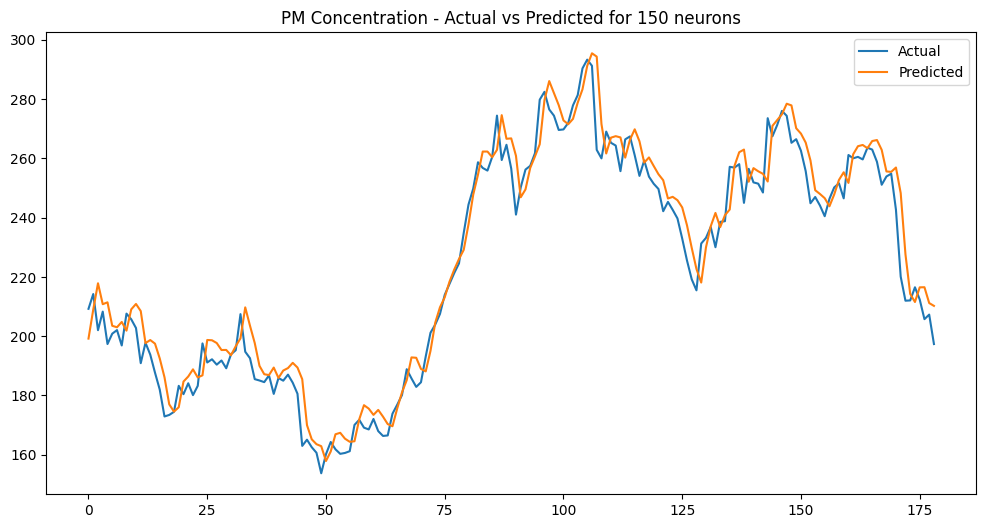

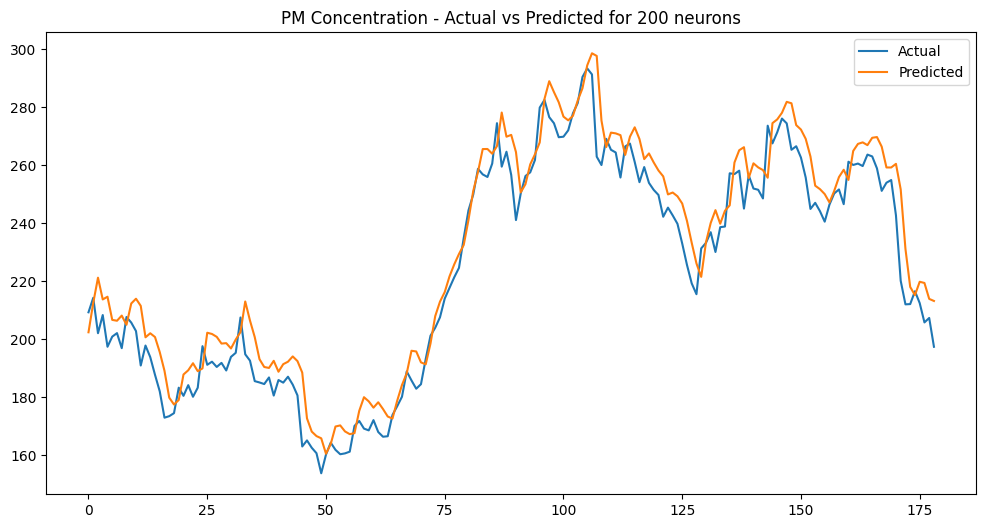

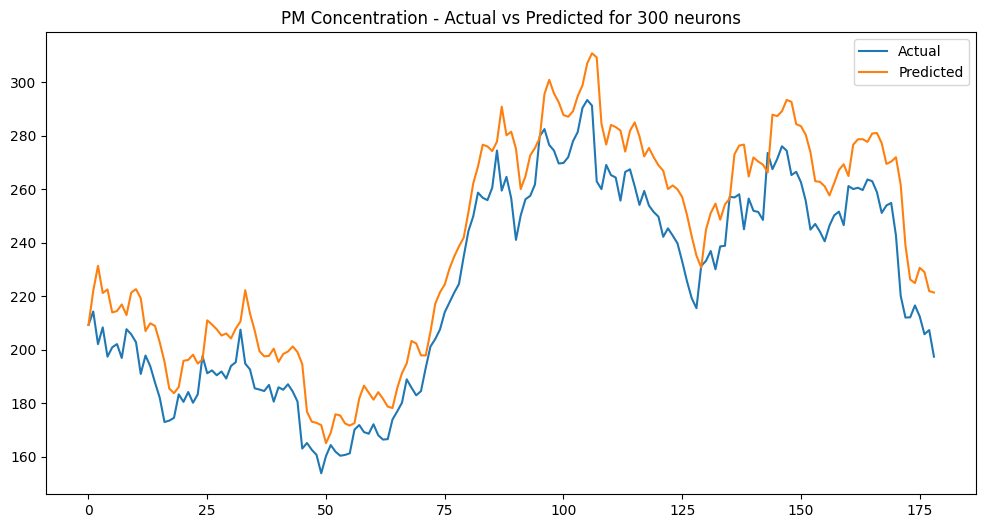

In [80]:
# Now you can plot the actual vs predicted values for each model
for i in range(len(neurons)):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(predictions[i], label='Predicted')
    plt.title(f"PM Concentration - Actual vs Predicted for {neurons[i]} neurons")
    plt.legend()
    plt.show()

In [81]:
from math import sqrt
rmse_values = []

for i in range(len(neurons)):
    rmse = sqrt(mean_squared_error(y_test, predictions[i]))
    rmse_values.append(rmse)
    print(f"RMSE for {neurons[i]} neurons: {rmse}")

RMSE for 50 neurons: 8.054651753111367
RMSE for 100 neurons: 9.778328595629361
RMSE for 150 neurons: 8.192315538614016
RMSE for 200 neurons: 9.998799085615403
RMSE for 300 neurons: 17.65169121288594


## Best Epoch Size = 20
## Best Batch Size = 1
## Best Neuron Size = 50

In [82]:
# Find the best neurone
neurons_final = [50]

# This will store the final loss for each number of neurons
neuron_loss = []

# This will store the running time for each number of neurons
neuron_time = []

# This will store the loss history for each number of neurons
loss_histories = []

# This will store the models
models = []

predictions = []  # This will store the predictions for each number of neurons

for n in neurons_final:
    model3 = Sequential()
    model3.add(LSTM(units=n, input_shape=(x_train.shape[1], 1)))
    model3.add(Dropout(0.2))
    model3.add(Dense(1))
    model3.compile(optimizer='adam', loss='mean_squared_error')

    start_time3 = time.time()
    history3 = model3.fit(x_train, y_train, epochs=epochs2, batch_size=batch_size2, validation_split=0.2)
    end_time3 = time.time()

    # Append the final loss for this number of neurons to neuron_loss
    neuron_loss.append(history3.history['loss'][-1])

    # Append the total time for this number of neurons to neuron_time
    neuron_time.append(end_time3 - start_time3)

    # Append the loss history for this number of neurons to loss_histories
    loss_histories.append(history3.history['loss'])
       # Generate predictions for this model and append to predictions list
    stock_pred_final = model3.predict(x_test)
    stock_pred_final = scaler.inverse_transform(stock_pred_final)
    predictions.append(stock_pred_final)

Epoch 1/20
526/526 [==============================] - 4s 6ms/step - loss: 0.0118 - val_loss: 0.0061
Epoch 2/20
526/526 [==============================] - 3s 6ms/step - loss: 0.0050 - val_loss: 0.0014
Epoch 3/20
526/526 [==============================] - 3s 6ms/step - loss: 0.0043 - val_loss: 0.0013
Epoch 4/20
526/526 [==============================] - 3s 6ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 5/20
526/526 [==============================] - 3s 6ms/step - loss: 0.0036 - val_loss: 9.0066e-04
Epoch 6/20
526/526 [==============================] - 3s 6ms/step - loss: 0.0043 - val_loss: 0.0021
Epoch 7/20
526/526 [==============================] - 3s 6ms/step - loss: 0.0031 - val_loss: 0.0010
Epoch 8/20
526/526 [==============================] - 3s 6ms/step - loss: 0.0026 - val_loss: 7.7511e-04
Epoch 9/20
526/526 [==============================] - 3s 6ms/step - loss: 0.0025 - val_loss: 7.3982e-04
Epoch 10/20
526/526 [==============================] - 3s 6ms/step - loss: 0.0021 - val_

In [83]:
# Get the last 60 days of scaled data
input_data = scaled_data[-60:, :]

# Empty list to store the 30 days of forecasted values
forecasted_prices = []

# Forecast the next 30 days
for i in range(30):
    # Reshape the data to be (1, 60, 1)
    input_data_reshaped = np.reshape(input_data, (1, 60, 1))
    
    # Predict the next closing price
    predicted_price = model3.predict(input_data_reshaped)
    
    # Append the predicted price to our list of forecasted_prices
    forecasted_prices.append(scaler.inverse_transform(predicted_price))
    
    # Append the predicted scaled value to the end of our input data for the next prediction
    input_data = np.append(input_data, predicted_price)
    
    # Drop the first value of our input data to keep it 60 days long
    input_data = input_data[1:]

# Convert forecasted_prices to a numpy array
forecasted_prices = np.array(forecasted_prices)

print("Forecasted Close prices for the next 30 days:")
print(forecasted_prices)


1/1 [==============================] - 0s 13ms/step
Forecasted Close prices for the next 30 days:
[[[203.9769 ]]

 [[204.23409]]

 [[205.2604 ]]

 [[206.75977]]

 [[208.55237]]

 [[210.52315]]

 [[212.59831]]

 [[214.73033]]

 [[216.88809]]

 [[219.05074]]

 [[221.20395]]

 [[223.33754]]

 [[225.444  ]]

 [[227.51767]]

 [[229.55432]]

 [[231.55052]]

 [[233.50375]]

 [[235.41197]]

 [[237.27374]]

 [[239.08792]]

 [[240.85376]]

 [[242.57077]]

 [[244.23875]]

 [[245.85767]]

 [[247.42766]]

 [[248.94899]]

 [[250.42215]]

 [[251.84761]]

 [[253.22604]]

 [[254.55812]]]


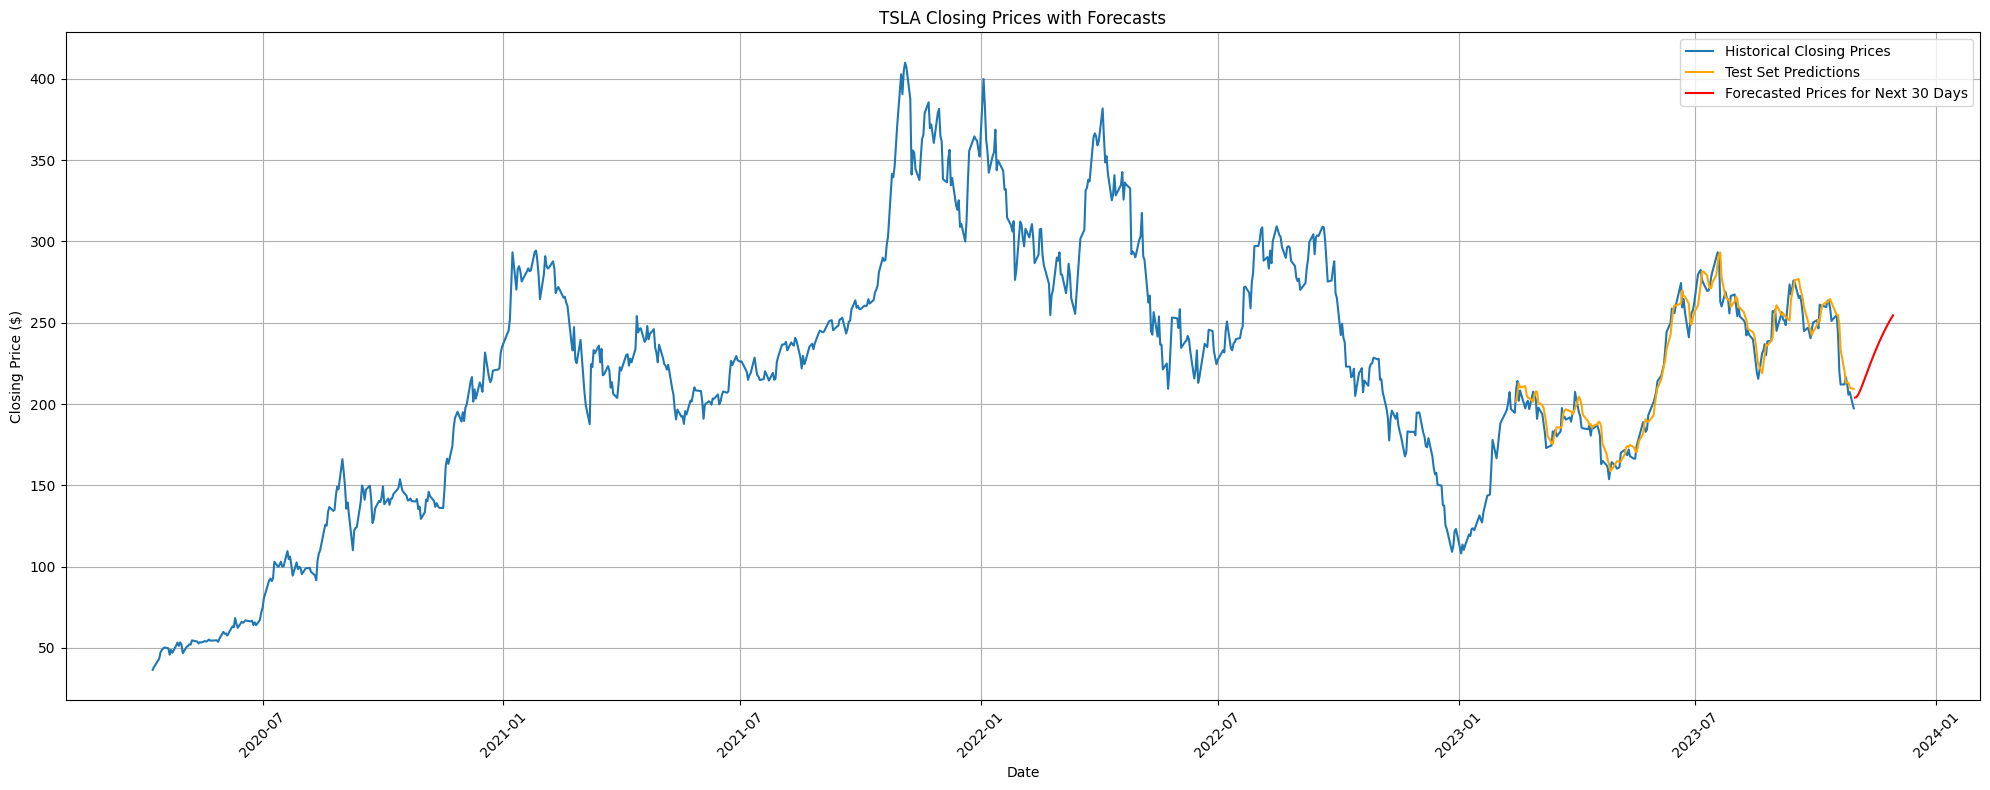

In [84]:
# Creating a time index for the forecasted prices
last_date = stock_data.index[-1]
forecast_dates = pd.date_range(start=last_date, periods=31)[1:]

# Plotting the data
plt.figure(figsize=(20, 8))
plt.plot(stock_data.index, stock_data['Close'], label='Historical Closing Prices')
plt.plot(stock_data.index[training_data_len:], predictions[-1], color='orange', label='Test Set Predictions')
plt.plot(forecast_dates, forecasted_prices.flatten(), color='red', label='Forecasted Prices for Next 30 Days')
plt.title('TSLA Closing Prices with Forecasts')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [85]:
rmse_values = []

for i in range(len(neurons_final)):
    rmse = sqrt(mean_squared_error(y_test, predictions[i]))
    rmse_values.append(rmse)
    print(f"RMSE for {neurons_final[i]} neurons: {rmse}")

RMSE for 50 neurons: 8.25895750342283


# Compare the predicted result with actual data

In [86]:
stock_data_Today = yf.download('TSLA', start='2020-04-08', end='2023-11-17')
stock_data_Today.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-11-10,210.029999,215.380005,205.690002,214.649994,214.649994,130994000
2023-11-13,215.600006,225.399994,211.610001,223.710007,223.710007,140447600
2023-11-14,235.029999,238.139999,230.720001,237.410004,237.410004,149771600
2023-11-15,239.289993,246.699997,236.449997,242.839996,242.839996,150354000
2023-11-16,239.490005,240.880005,230.960007,233.589996,233.589996,136177700


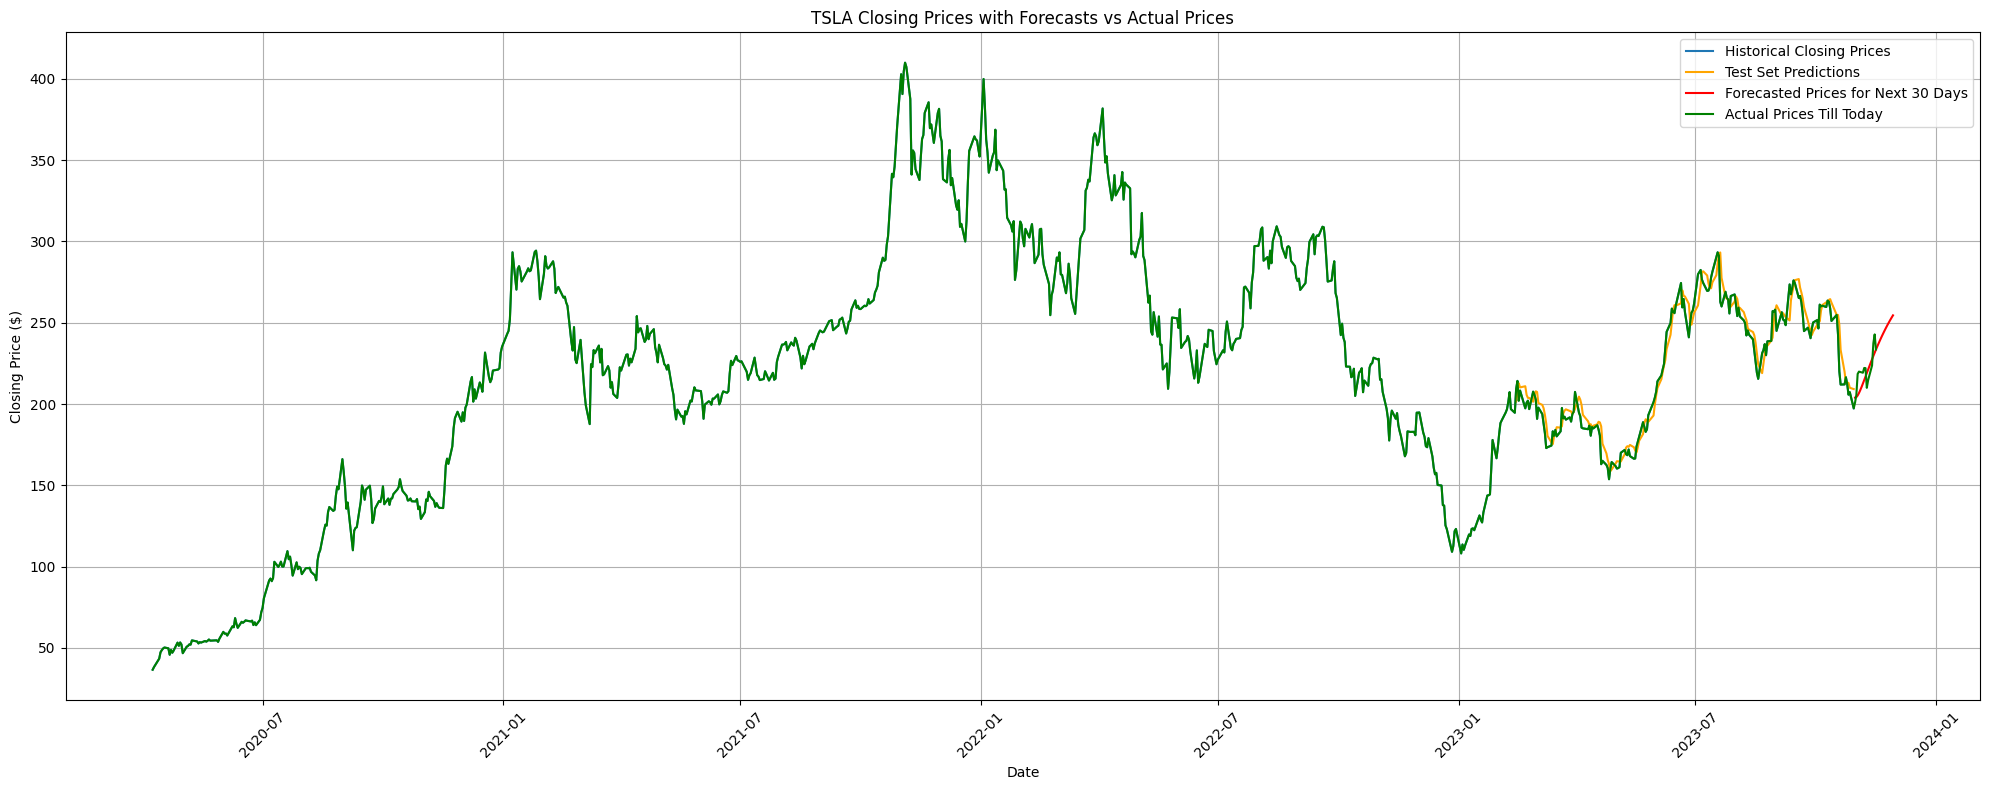

In [87]:
# Creating a time index for the forecasted prices (continuing from your provided code)
last_date = stock_data.index[-1]
forecast_dates = pd.date_range(start=last_date, periods=31)[1:]

# Plotting the historical, forecasted, and actual data
plt.figure(figsize=(20, 8))
plt.plot(stock_data.index, stock_data['Close'], label='Historical Closing Prices')
plt.plot(stock_data.index[training_data_len:], predictions[-1], color='orange', label='Test Set Predictions')
plt.plot(forecast_dates, forecasted_prices.flatten(), color='red', label='Forecasted Prices for Next 30 Days')
plt.plot(stock_data_Today.index, stock_data_Today['Close'], color='green', label='Actual Prices Till Today')
plt.title('TSLA Closing Prices with Forecasts vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Final Report 

We conducted an analysis of Tesla's stock price performance, utilising historical data spanning from 4th August 2020 to 31st October 2023. Our objective was to predict the stock's trend for November 2023 and assess the reliability of our forecast. This report presents our findings and recommendations for potential investors.

### Analysis and Forecast for November 2023:

Upon analysing the historical data, our model indicated an upward trend in Tesla's stock price for the upcoming 30 days, suggesting that the stock is likely to increase in value.

### Comparison with Actual Prices:

We compared our forecasted trend (represented by the red line) with the actual prices (represented by the green line) for the month of November 2023, as illustrated in the plot titled "TSLA Closing Prices With Forecasts vs. Actual Prices." The result of our analysis showed that our forecast accurately represented the upward trend in Tesla's stock price. This alignment between our prediction and actual performance suggests that our forecasting model is reliable.

### Investment Recommendation:

Given the reliability of our prediction for the next 30 days, we believe that investing in Tesla (TSLA) during this period could yield favourable returns.

### Room for Enhancement:

While our current model has demonstrated its effectiveness in forecasting monthly trends, there is room for improvement. One potential enhancement is to analyse the stock using hourly data and predict hourly prices for day trading. This approach may help reduce investment risk, especially for those who prefer shorter-term investments, as it provides a more granular view of the stock's price movements throughout the day.

### Conclusion:

In conclusion, our analysis of Tesla's stock price performance for November 2023 has yielded a positive outlook, suggesting an upward trend. The accuracy of our forecast compared to actual prices reinforces the reliability of our model. Investors looking to capitalise on this trend may find our analysis valuable. Additionally, exploring the use of hourly data for day trading predictions represents a promising avenue for further improvement in our forecasting strategies.